In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import torch.optim as optim
from tqdm import tqdm
from IPython.display import display, clear_output

In [2]:
class ActorNetwork(nn.Module):

    def __init__(self, in_states, out_actions):
        super(ActorNetwork, self).__init__()

        # defining actor neural network (state as input, action as output)
        self.fc1 = nn.Linear(in_states, 32)
        self.ln1 = nn.LayerNorm(32)

        self.fc2 = nn.Linear(32, 64)
        self.ln2 = nn.LayerNorm(64)

        self.fc3 = nn.Linear(64, 128)
        self.ln3 = nn.LayerNorm(128)

        self.fc4 = nn.Linear(128, 256)
        self.ln4 = nn.LayerNorm(256)

        self.fc5 = nn.Linear(256, 256)
        self.ln5 = nn.LayerNorm(256)

        self.fc6 = nn.Linear(256, 64)
        self.ln6 = nn.LayerNorm(64)

        self.fc7 = nn.Linear(64, out_actions)

        self.reset_parameters()

    def reset_parameters(self):

        # for loop to initialise weights
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6, self.fc7]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):

        # defining network processing pipeline
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        x = F.relu(self.ln4(self.fc4(x)))
        x = F.relu(self.ln5(self.fc5(x)))
        x = F.relu(self.ln6(self.fc6(x)))
        return torch.tanh(self.fc7(x))
    
class CriticNetwork(nn.Module):

    def __init__(self, in_states, out_actions):
        super(CriticNetwork, self).__init__()

        # defining critic neural network, estimates Q-value for state, action pair
        self.fc1 = nn.Linear(in_states + out_actions, 256)
        self.ln1 = nn.LayerNorm(256)

        self.fc2 = nn.Linear(256, 256)
        self.ln2 = nn.LayerNorm(256)

        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)

        self.fc4 = nn.Linear(128, 64)
        self.ln4 = nn.LayerNorm(64)

        self.fc5 = nn.Linear(64, 32)
        self.ln5 = nn.LayerNorm(32)

        self.fc6 = nn.Linear(32, 1)

        self.reset_parameters()

    def reset_parameters(self):

        # for loop to initialise weights
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6]:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, state, action):

        # defining network processing pipeline
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.ln1(self.fc1(x)))
        x = F.relu(self.ln2(self.fc2(x)))
        x = F.relu(self.ln3(self.fc3(x)))
        x = F.relu(self.ln4(self.fc4(x)))
        x = F.relu(self.ln5(self.fc5(x)))
        return self.fc6(x)

class ReplayBuffer:

    # initialising storage of past experiences or transitions 
    def __init__(self, capacity):
        self.capacity = capacity # max number of transitions that can be stored in the buffer
        self.buffer = []
        self.position = 0

    # pushes a transition to the buffer
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, float(done))
        self.position = (self.position + 1) % self.capacity

    # returns random batch of transitions 
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.FloatTensor(np.array(states)),
                torch.FloatTensor(np.array(actions)),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(np.array(next_states)),
                torch.FloatTensor(dones).unsqueeze(1))

    # returns the number of transitions currently stored in the buffer
    def __len__(self):
        return len(self.buffer)

class TD3Agent:

    # initialising hyperparameters
    def __init__(self, env, gamma, batch_size, memory_size, beta, actor_lr, critic_lr, sigma, start_time,
                 policy_noise=0.15, noise_clip=0.4, exploration_noise_std=0.1):
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.beta = beta
        self.sigma = sigma
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.exploration_noise_std = exploration_noise_std
        self.time = 0
        self.start_time = start_time
        self.policy_delay = 2

        self.memory = ReplayBuffer(memory_size)
        self.num_action = env.action_space.shape[0]
        self.num_states = env.observation_space.shape[0]
        self.max_action = float(env.action_space.high[0])

        self.actor = ActorNetwork(self.num_states, self.num_action)
        self.target_actor = copy.deepcopy(self.actor)

        self.critic1 = CriticNetwork(self.num_states, self.num_action)
        self.critic2 = CriticNetwork(self.num_states, self.num_action)
        self.target_critic1 = copy.deepcopy(self.critic1)
        self.target_critic2 = copy.deepcopy(self.critic2)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=critic_lr)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=critic_lr)

    def update_networks(self):

        # checks if enough transitions are stored on buffer then samples
        if len(self.memory) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # computes target q-value
        with torch.no_grad():
            noise = (torch.randn_like(actions) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            next_actions = (self.target_actor(next_states) + noise).clamp(-1.0, 1.0)

            q1_target = self.target_critic1(next_states, next_actions)
            q2_target = self.target_critic2(next_states, next_actions)
            q_target = rewards + self.gamma * (1 - dones) * torch.min(q1_target, q2_target)

        # compute current q-value then calculates loss
        q1 = self.critic1(states, actions)
        q2 = self.critic2(states, actions)
        critic1_loss = F.mse_loss(q1, q_target)
        critic2_loss = F.mse_loss(q2, q_target)

        # update critic network 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()

        # update critic network 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()

        # delayed update for the actor
        if self.time % self.policy_delay == 0:
            actor_loss = -self.critic1(states, self.actor(states)).mean()
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            self.soft_update()

    def soft_update(self):
        
        # slowly blending weights of actor/critic to target network
        for t_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            t_param.data.copy_(self.beta * param.data + (1 - self.beta) * t_param.data)
        for t_param, param in zip(self.target_critic1.parameters(), self.critic1.parameters()):
            t_param.data.copy_(self.beta * param.data + (1 - self.beta) * t_param.data)
        for t_param, param in zip(self.target_critic2.parameters(), self.critic2.parameters()):
            t_param.data.copy_(self.beta * param.data + (1 - self.beta) * t_param.data)

    def run_episode(self):
        state = self.env.reset()[0]
        total_reward = 0
        done = False
        while not done:
            action = self.actor(torch.tensor(state, dtype=torch.float32)).detach().numpy()
            action += np.random.normal(0, self.exploration_noise_std, size=self.num_action)
            action = np.clip(action, -1.0, 1.0)

            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            clipped_reward = np.clip(reward, -1, 1)
            self.memory.push(state, action, clipped_reward, next_state, done)

            if self.time > self.start_time:
                self.update_networks()

            state = next_state
            total_reward += reward
            self.time += 1

        return total_reward

    def train(self, num_episodes):
        plt.ion()
        fig, ax = plt.subplots()
        reward_history = []
        for episode in range(num_episodes):
            ep_reward = self.run_episode()
            reward_history.append(ep_reward)
            percentage = ((episode/num_episodes) * 100)
            print(f"Training Progress: {percentage:.2f}%")
            print(f"Episode {episode}/{num_episodes} - Reward: {ep_reward:.2f}")
            ax.clear()
            ax.plot(reward_history)
            ax.set_title("TD3 Training Progress")
            ax.set_xlabel("Episode")
            ax.set_ylabel("Reward")
            display(fig)
            clear_output(wait=True)
        plt.ioff()
        plt.show()
        return reward_history

    def watch(self, episodes=3, render=True):
        for ep in range(episodes):
            state = self.env.reset()[0]
            done = False
            total_reward = 0
            while not done:
                if render:
                    self.env.render()
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    action = self.actor(state_tensor).squeeze().numpy()
                state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                total_reward += reward
            print(f"Episode {ep + 1} - Total Reward: {total_reward:.2f}")
        self.env.close()


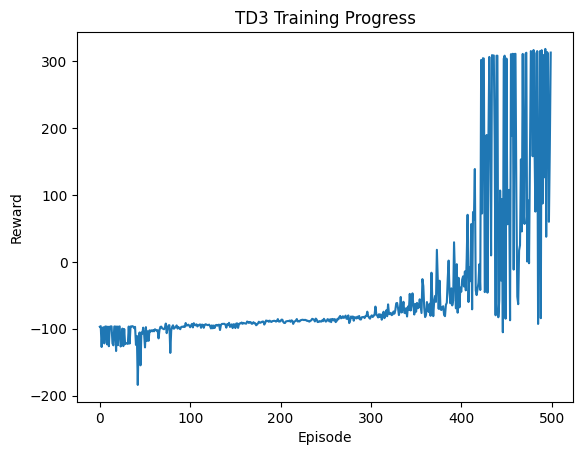

In [4]:
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode = "human")
agent = TD3Agent(env=env, gamma=0.99, batch_size = 256, memory_size=int(1e6), beta = 0.05, actor_lr = 1e-4, critic_lr = 1e-3, sigma = 0.2, start_time = 5e3)
num_of_episodes = 500

reward_history = agent.train(num_of_episodes)